## Convolutional Autoencoder

fonte: https://blog.keras.io/building-autoencoders-in-keras.html

Este notebook apresenta autocodificadores convolucionais. Utiliza as amostras do MNIST para ilustrar o autocodificador.

In [1]:
%matplotlib inline
import os
import keras.backend as K
K.set_image_data_format("channels_first")

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plot

import sys
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.datasets import mnist

sys.path.append('../src/')
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

## Código de apoio ao treinamento

In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt)    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=batch_size, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass
    model, cb = load_model_and_history(model_name)
    return model, cb

In [28]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

In [29]:
testing = False
if testing:
    n_samples = 2000
    X_train = x_train[:n_samples]
    n_samples_test = 500
    X_test = x_test[:n_samples_test]
else:
    X_train = x_train
    X_test = x_test
print(X_train.shape, X_test.shape)

(60000, 1, 28, 28) (10000, 1, 28, 28)


## Criando a rede

In [9]:
input_img = Input(shape=(1, 28, 28))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='valid')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (1, 1, 1) i.e. 2-dimensional

x = UpSampling2D((2, 2))(encoded)   # 2x2
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)         # 4x4
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)         # 8x8
x = Conv2D(8, (2, 2), activation='relu', padding='valid')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 28, 28)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 14, 14)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 14, 14)         1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 7, 7)           0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 7, 7)           584       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 4, 4)           0         
__________

[INFO] loading model...
[INFO] training for 71 epochs...


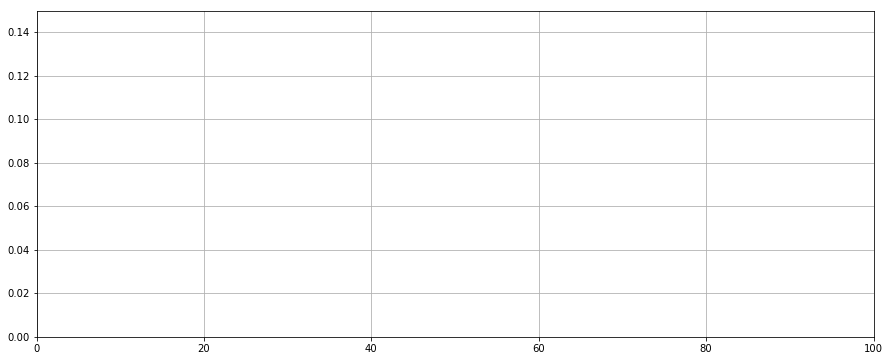

In [30]:
model_name = '../../models/autoencoder_conv_1'
fit_params = {
    'model_name': model_name,
    'loss':       'mse',
    'opt':        Adam(),
    'batch_size': 128, 
    'nepochs':    100,
    'patience':   10,
    'ploss':      0.15,
    'reset':      False,
}

model_trained,_ = train_network(autoencoder, 
                                X_train, X_train, 
                                X_test, X_test, **fit_params);

In [12]:
decoded_imgs = model_trained.predict(x_test)

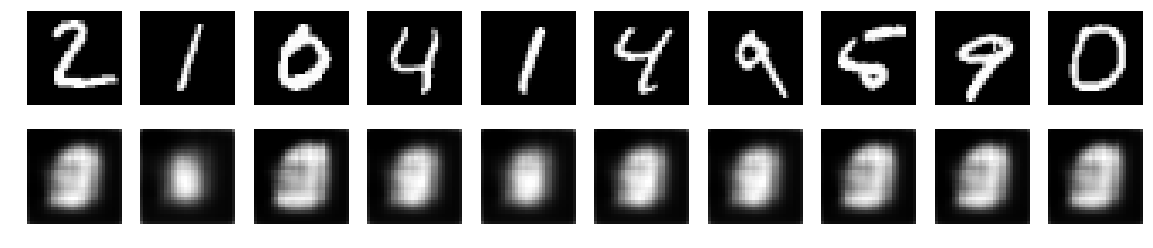

In [13]:
n = 10
plot.figure(figsize=(20, 4))
plot.gray()
for i in range(1,n+1):
    # display original
    ax = plot.subplot(2, n, i)
    plot.imshow(x_test[i].reshape(28, 28))
    plot.axis('off')

    # display reconstruction
    ax = plot.subplot(2, n, i + n)
    plot.imshow(decoded_imgs[i].reshape(28, 28))
    plot.axis('off')
plot.show()

## Aprendizados com este notebook

